In [1]:
# Instala o fbprohet

#!pip install fbprophet

# Caso o comando acima não funcione, executar o comando abaixo
#conda install -c conda-forge pystan
#conda install -c conda-forge fbprophet

In [2]:
import pandas as pd
import numpy as np

import fbprophet
from fbprophet import Prophet
#import warnings
import matplotlib.pyplot as plt
#warnings.filterwarnings('ignore'

import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [3]:
# Configura o número de threads a ser executado

import os
os.environ['NUMEXPR_MAX_THREADS'] = '32'
os.environ['NUMEXPR_NUM_THREADS'] = '16'

In [4]:
# Define algumas variáveis
pasta_datasets = '../Datasets/'
arquivo_combustiveis_dolar_ipca_nacional = 'df_combustiveis_dolar_ipca_nacional.csv'

In [5]:
# Efetua a leitura do arquivo 'combustiveis_dolar_ipca_nacional.csv' 

print(pasta_datasets+arquivo_combustiveis_dolar_ipca_nacional)
df_combustiveis_dolar_ipca_nacional  =  pd.read_csv(pasta_datasets+arquivo_combustiveis_dolar_ipca_nacional,sep = ';',low_memory=False, parse_dates=['Data'],dayfirst = True,encoding='utf-8')

# Cria um novo índice com a coluna 'Data' 
df_combustiveis_dolar_ipca_nacional.set_index(['Data'], inplace=True)

display(df_combustiveis_dolar_ipca_nacional)
df_combustiveis_dolar_ipca_nacional.info()


../Datasets/df_combustiveis_dolar_ipca_nacional.csv


,ValorVendaGasolina,ValorVendaEtanol,CotacaoDolarVenda,Indice_Dez93,Ipca_Mensal
Data,,,,,
2005-01-03,2.411366,1.750419,2.6682,2412.83,0.58
2005-01-04,2.406277,1.719137,2.6887,2412.83,0.58
2005-01-05,2.389795,1.740931,2.7096,2412.83,0.58
2005-01-06,2.424676,1.704239,2.7207,2412.83,0.58
2005-01-10,2.414220,1.744700,2.6973,2412.83,0.58
...,...,...,...,...,...
2021-12-27,6.668185,5.580209,5.6650,6120.04,0.73
2021-12-28,6.692192,5.629191,5.6438,6120.04,0.73
2021-12-29,6.726590,5.624709,5.6619,6120.04,0.73


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3511 entries, 2005-01-03 to 2021-12-31
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ValorVendaGasolina  3511 non-null   float64
 1   ValorVendaEtanol    3511 non-null   float64
 2   CotacaoDolarVenda   3511 non-null   float64
 3   Indice_Dez93        3511 non-null   float64
 4   Ipca_Mensal         3511 non-null   float64
dtypes: float64(5)
memory usage: 164.6 KB


In [6]:
# GASOLINA

In [7]:
# Carrega o dataset referente à Gasolina e renomeia as colunas

df_prophet_gasolina = df_combustiveis_dolar_ipca_nacional['ValorVendaGasolina'] 

df_prophet_gasolina = df_prophet_gasolina.reset_index(level=['Data'])

df_prophet_gasolina = df_prophet_gasolina.rename(columns={'Data':'ds','ValorVendaGasolina':'y'})

In [8]:
df_prophet_gasolina

,ds,y
0,2005-01-03,2.411366
1,2005-01-04,2.406277
2,2005-01-05,2.389795
3,2005-01-06,2.424676
4,2005-01-10,2.414220
...,...,...
3506,2021-12-27,6.668185
3507,2021-12-28,6.692192
3508,2021-12-29,6.726590
3509,2021-12-30,6.673051


In [9]:
# Vamos realizar a previsão dos últimos 04 anos (2018 a 2021) comparando com o valor real

treino = df_prophet_gasolina.loc[df_prophet_gasolina['ds']<='2017-12-31']
teste  = df_prophet_gasolina.loc[df_prophet_gasolina['ds']>='2018-01-01']

In [10]:
# Instancia um objeto Prophet e cria o modelo

# modelo aditivo
forecaster_add = Prophet(seasonality_mode='additive', weekly_seasonality=False, daily_seasonality=False)
model_add = forecaster_add.fit(treino)

# modelo multiplicativo
forecaster_mul = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
model_mul = forecaster_mul.fit(treino)

In [11]:
print(model_add.seasonalities)
print(model_mul.seasonalities)

OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])
OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'multiplicative', 'condition_name': None})])


In [12]:
# Cria um dataframe com os períodos no futuro (48 meses)
future_ds = model_add.make_future_dataframe(periods=48, freq='MS', include_history=True)

In [13]:
# Realiza as predições
prediction_add = model_add.predict(future_ds)
prediction_mul = model_mul.predict(future_ds)

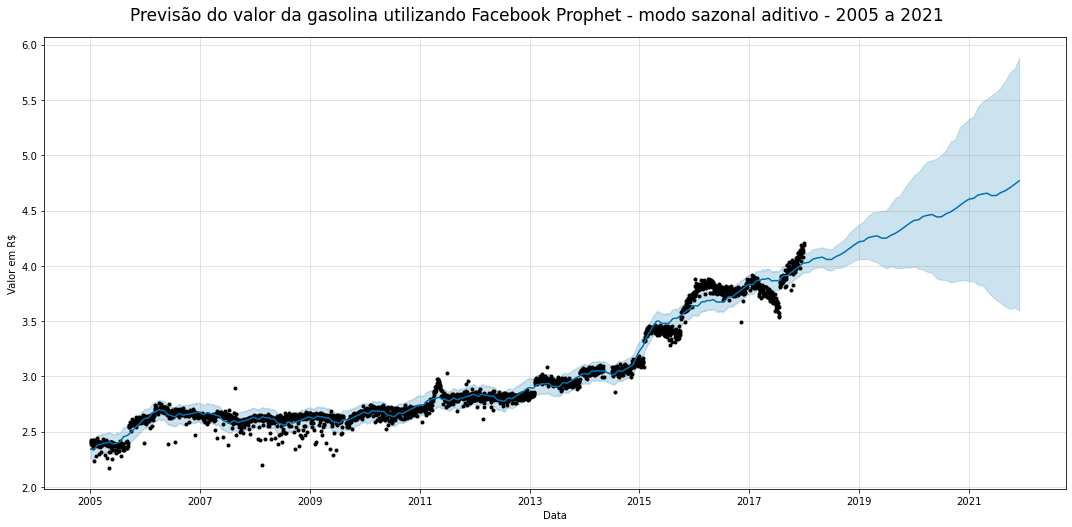

In [14]:
# Plota o valor efetivo "y" (pontos pretos), a previsão "yhat" é a linha azul escura
# A faixa azul clara representa o intervalo definido pelo limite inferior "yhat_lower" e limite superior "yhat_upper"

# modelo aditivo
fig = model_add.plot(prediction_add, figsize=(15,7), xlabel = 'Data', ylabel = 'Valor em R$', );
fig.suptitle('Previsão do valor da gasolina utilizando Facebook Prophet - modo sazonal aditivo - 2005 a 2021', 
             fontsize=17, y=1.04);

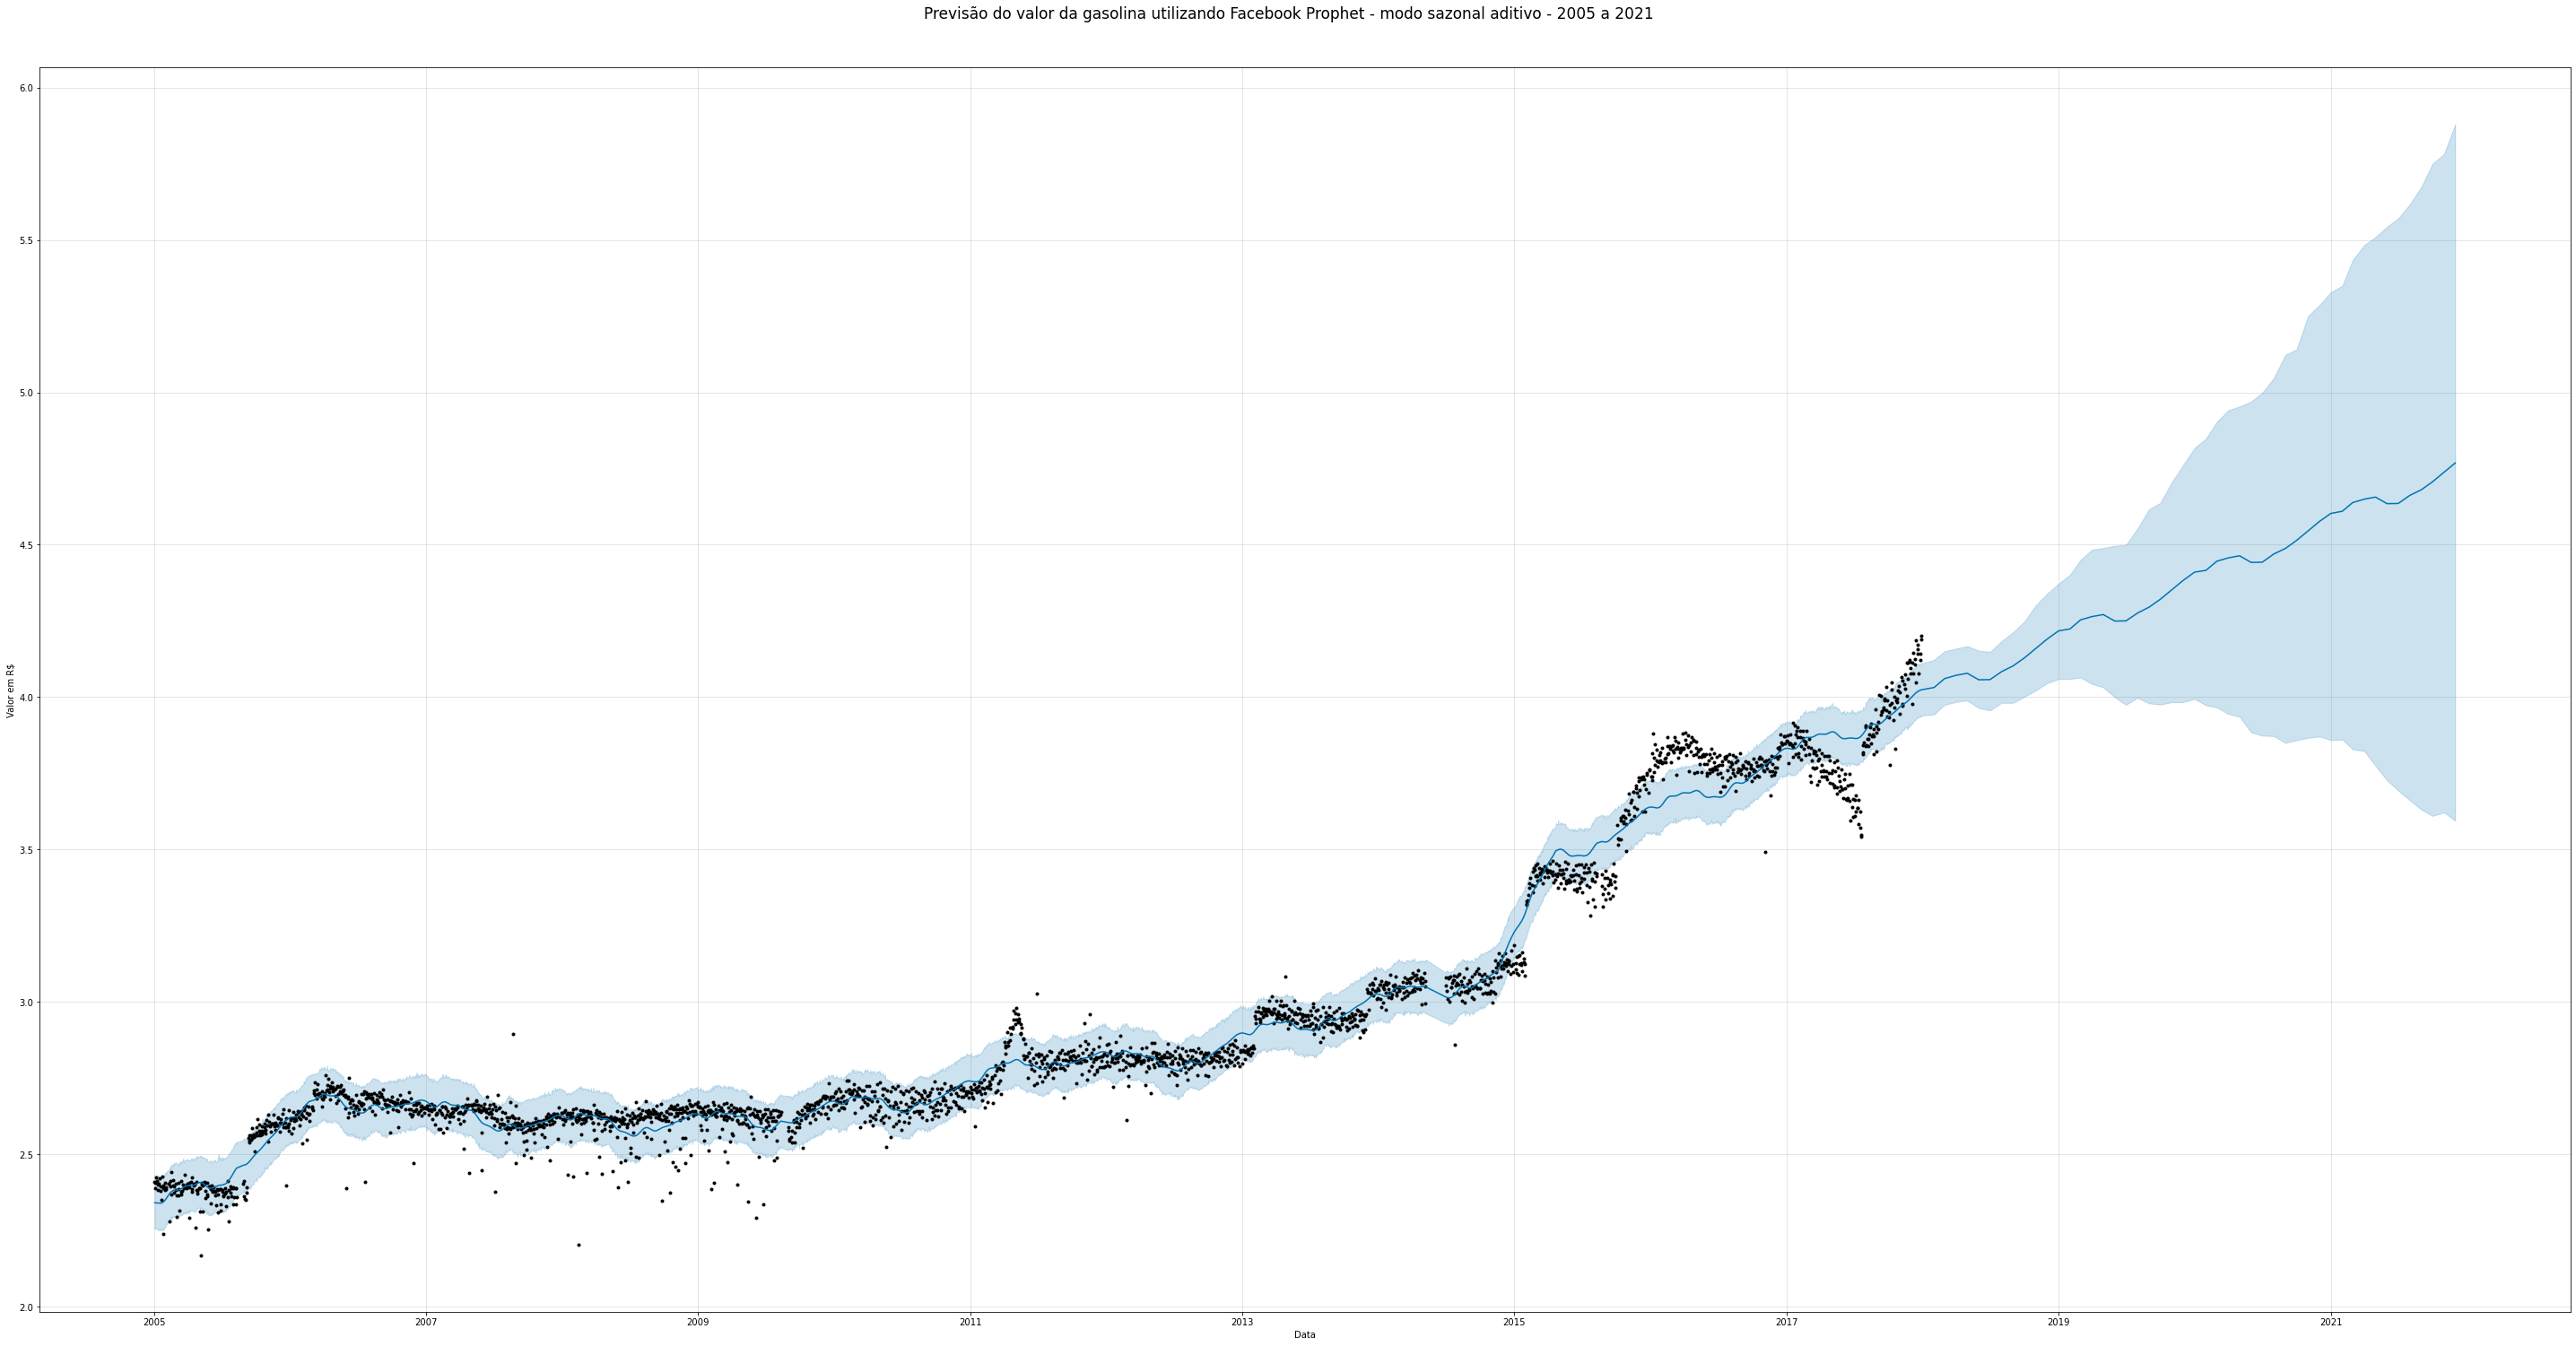

In [15]:
# TAMANHO MAIOR

# modelo aditivo
fig = model_add.plot(prediction_add, figsize=(40,20), xlabel = 'Data', ylabel = 'Valor em R$', );
fig.suptitle('Previsão do valor da gasolina utilizando Facebook Prophet - modo sazonal aditivo - 2005 a 2021', 
             fontsize=17, y=1.04);

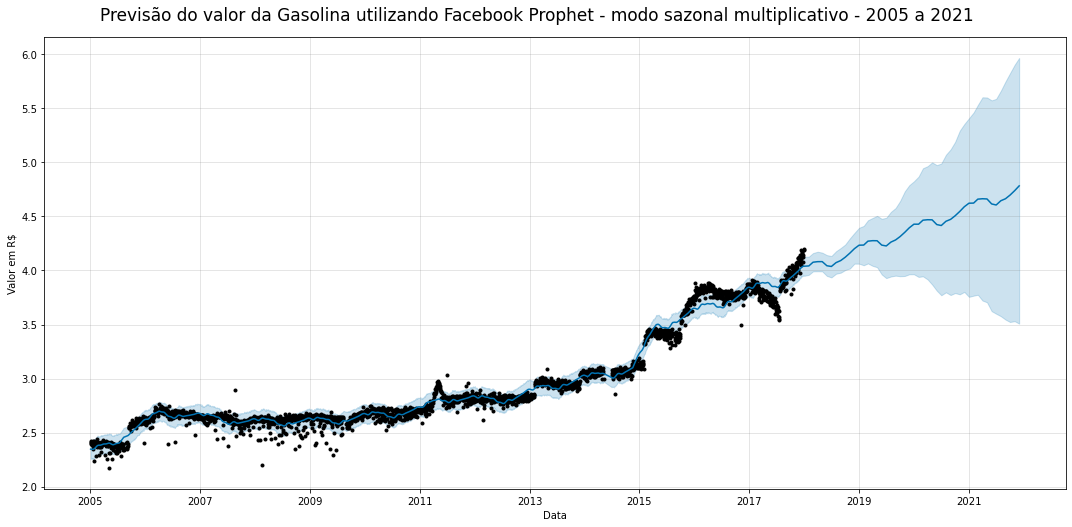

In [16]:
# Plota o valor efetivo "y" (pontos pretos), a previsão "yhat" é a linha azul escura
# A faixa azul clara representa o intervalo definido pelo limite inferior "yhat_lower" e limite superior "yhat_upper"

# modelo multiplicativo
fig = model_mul.plot(prediction_mul, figsize=(15,7), xlabel = 'Data', ylabel = 'Valor em R$');
fig.suptitle('Previsão do valor da Gasolina utilizando Facebook Prophet - modo sazonal multiplicativo - 2005 a 2021', 
             fontsize=17, y=1.04);

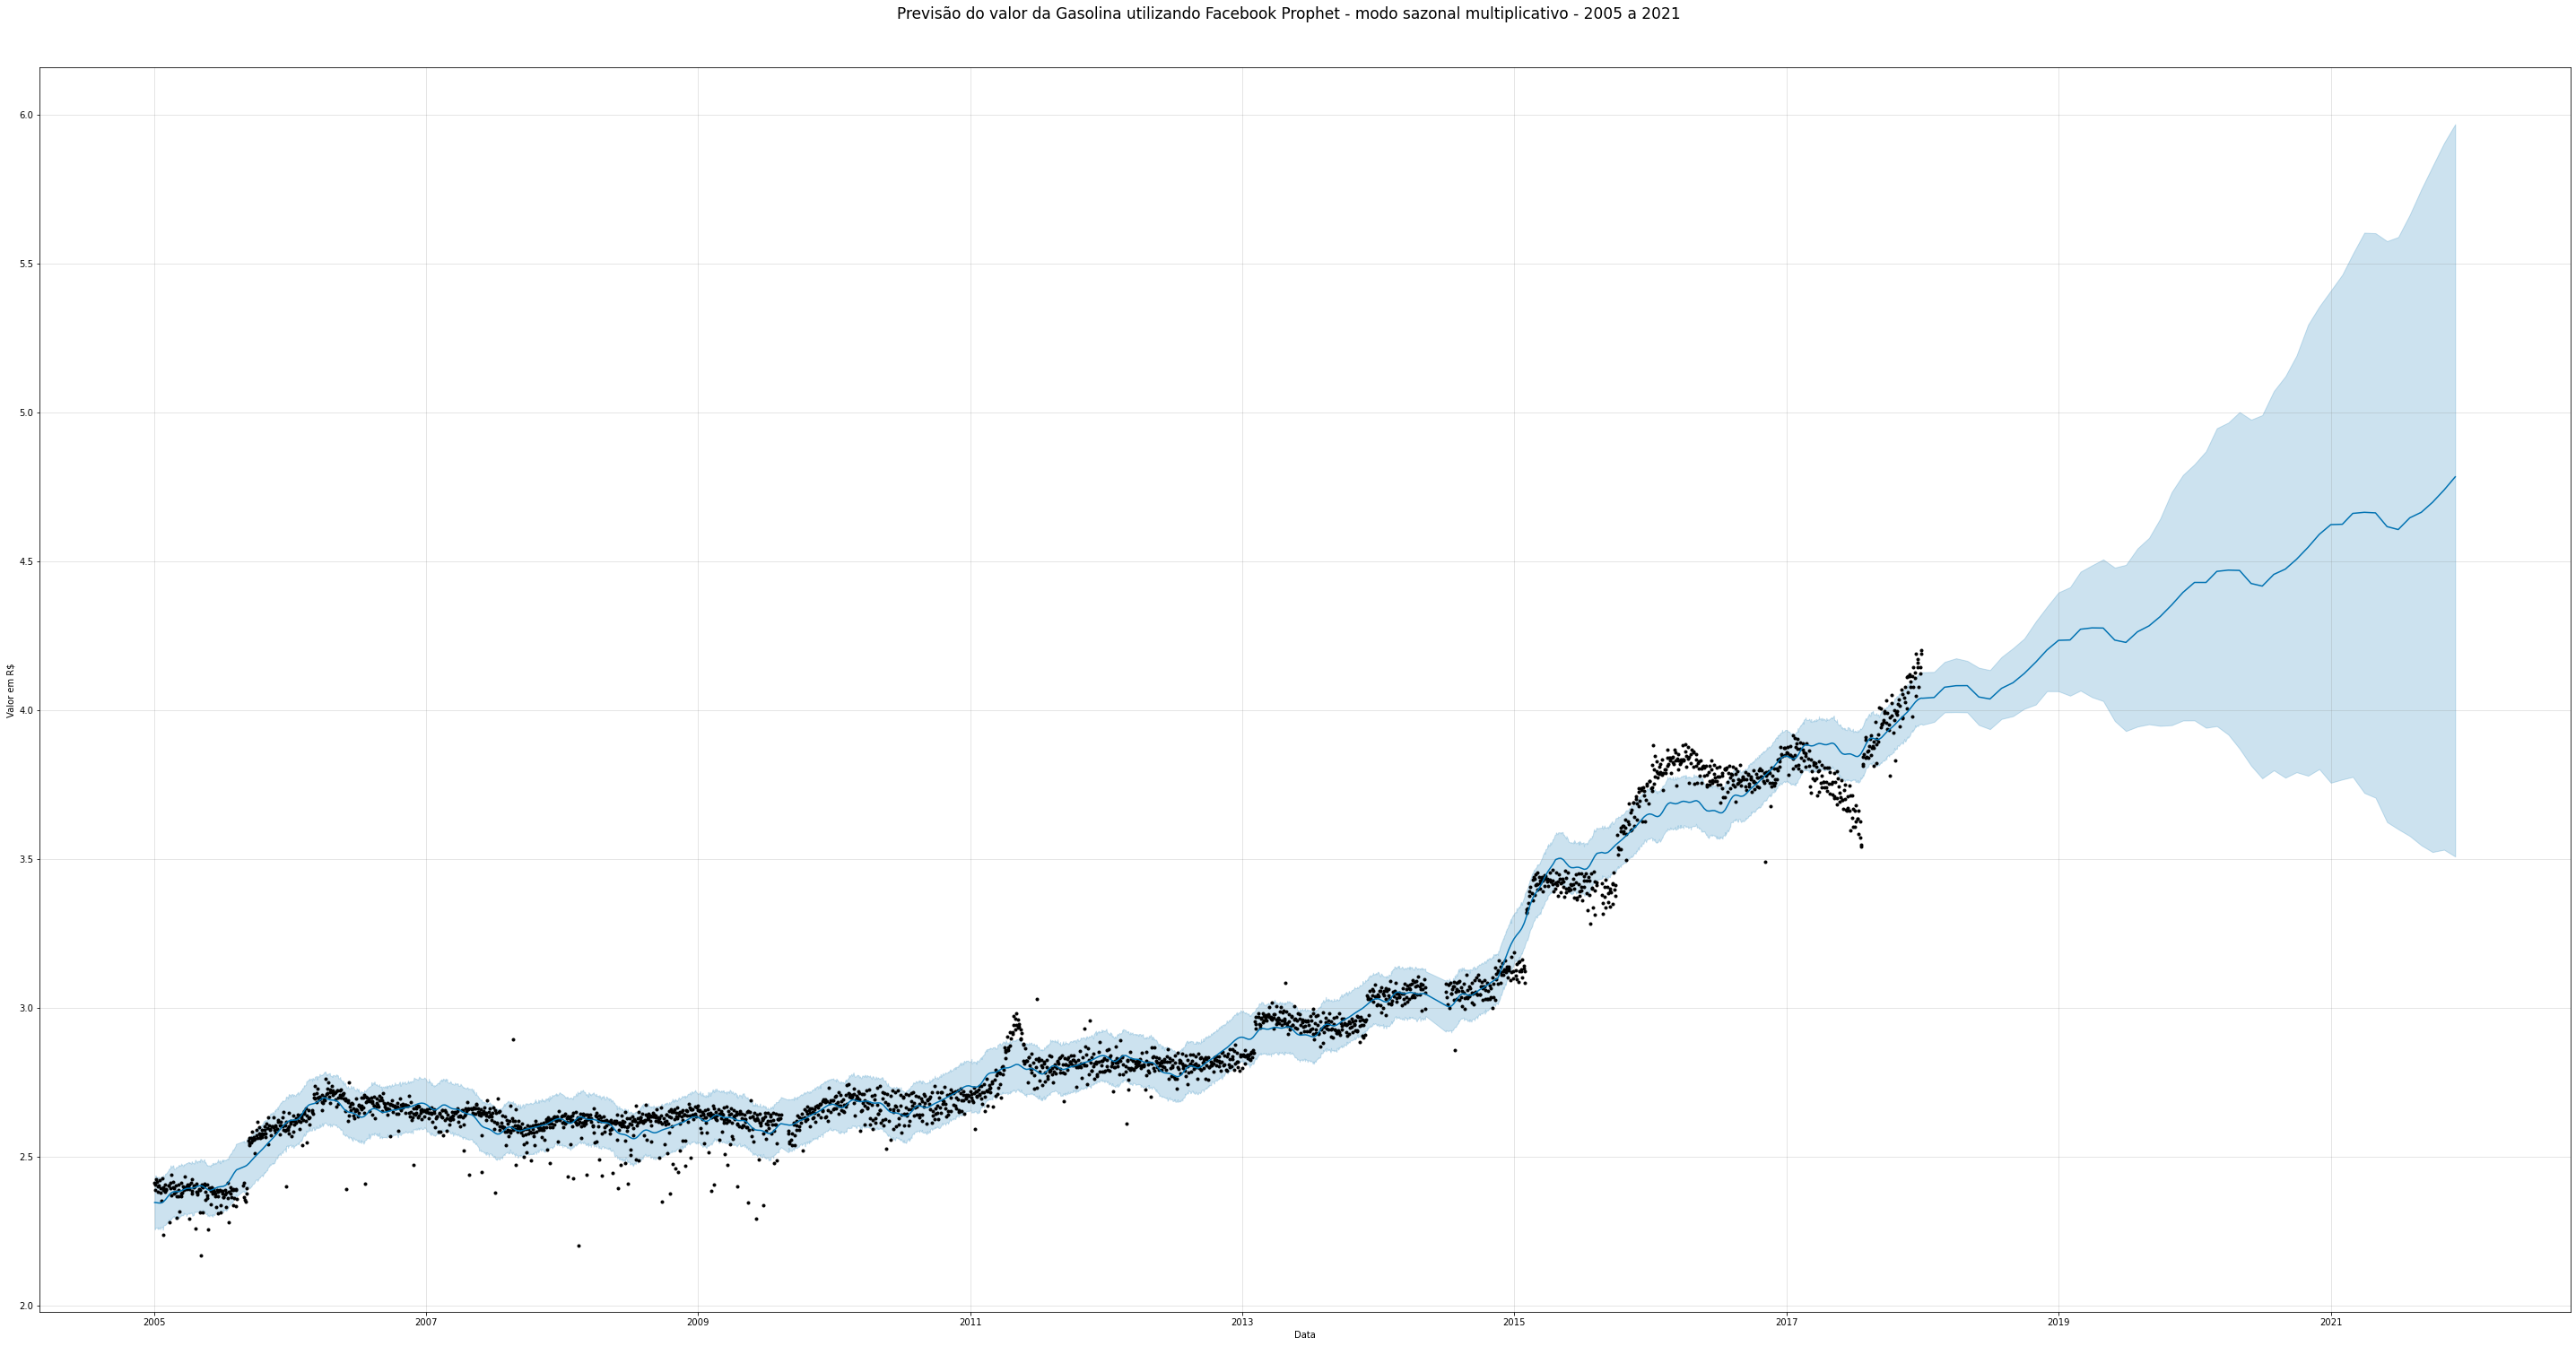

In [17]:
# TAMANHO MAIOR

# modelo multiplicativo
fig = model_mul.plot(prediction_mul, figsize=(40,20), xlabel = 'Data', ylabel = 'Valor em R$');
fig.suptitle('Previsão do valor da Gasolina utilizando Facebook Prophet - modo sazonal multiplicativo - 2005 a 2021', 
             fontsize=17, y=1.04);

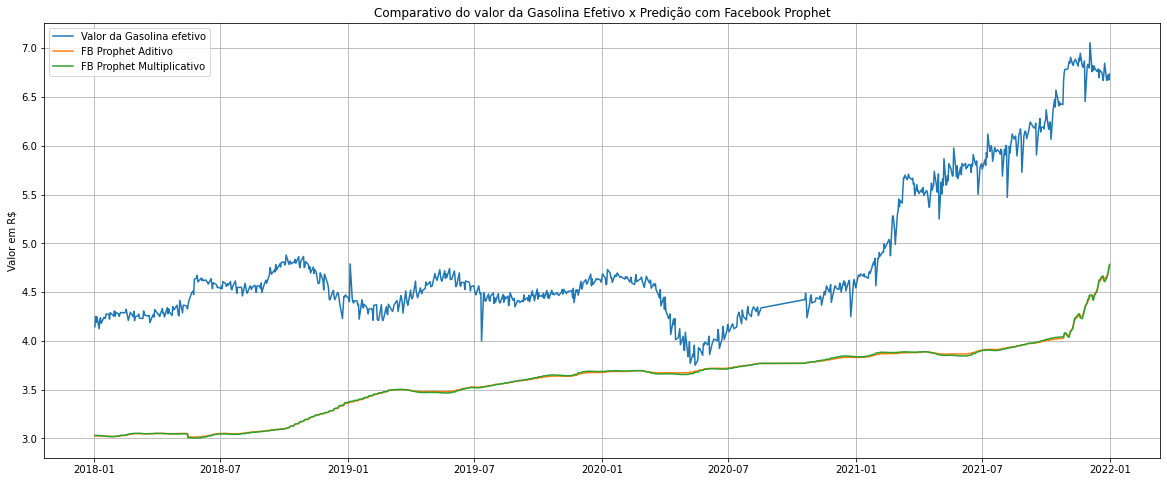

In [18]:
# Comparativo valores das predições e efetivos
plt.figure(figsize = (20,8))
plt.plot(teste['ds'], teste['y'], label = "Valor da Gasolina efetivo")
plt.plot(teste['ds'], prediction_add['yhat'][-829:], label = "FB Prophet Aditivo")
plt.plot(teste['ds'], prediction_mul['yhat'][-829:], label = "FB Prophet Multiplicativo")
plt.title('Comparativo do valor da Gasolina Efetivo x Predição com Facebook Prophet')
plt.ylabel('Valor em R$')
plt.legend(loc = 'upper left')
plt.grid(True, axis='both')
plt.show()

In [19]:
#yhat é o valor predito, yhat_lower e upper são os valores para intervalo de
#confiança
prediction_mul[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2725,2021-08-01,4.645325,3.576916,5.662850
2726,2021-09-01,4.663915,3.545665,5.748747
2727,2021-10-01,4.697298,3.523156,5.825406
2728,2021-11-01,4.738597,3.530969,5.903647
2729,2021-12-01,4.782899,3.507979,5.967034


In [20]:
# Testes de performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

efetivo = teste['y']
predicao_add = prediction_add['yhat'][-829:]
predicao_mul = prediction_mul['yhat'][-829:]

# Calcula o erro RMSE
rmse_add = np.sqrt(mean_squared_error(efetivo, predicao_add))
rmse_mul = np.sqrt(mean_squared_error(efetivo, predicao_mul))

# Cálculo do coeficiente de determinação, também chamado de R²
r2_add = r2_score(efetivo, predicao_add)
r2_mul = r2_score(efetivo, predicao_mul)

# Mean absolute percentage error (MAPE) - a measure of prediction accuracy of a forecasting method in statistics
mape_add = mean_absolute_percentage_error(efetivo, predicao_add) * 100
mape_mul = mean_absolute_percentage_error(efetivo, predicao_mul) * 100

In [21]:
print(f'RMSE aditivo: {rmse_add:.2f}')
print(f'RMSE multiplicativo: {rmse_mul:.2f}\n')

print(f'R2 aditivo: {r2_add:.2f}')
print(f'R2 multiplicativo: {r2_mul:.2f}\n')

print(f'MAPE aditivo: {mape_add:.2f}%')
print(f'MAPE multiplicativo: {mape_mul:.2f}%')

RMSE aditivo: 1.39
RMSE multiplicativo: 1.39

R2 aditivo: -2.36
R2 multiplicativo: -2.36

MAPE aditivo: 25.18%
MAPE multiplicativo: 25.18%


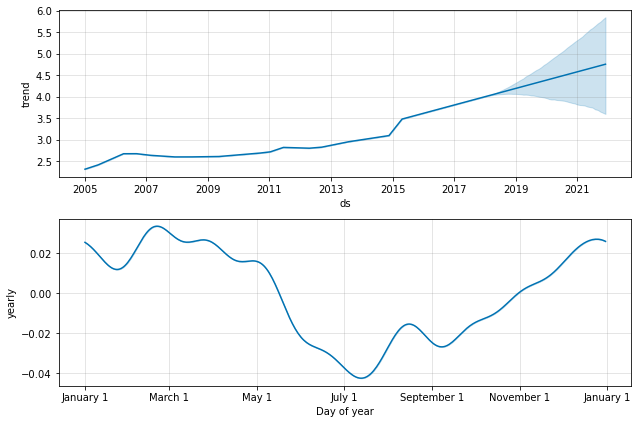

In [22]:
# Plota os componentes de tendência (trend) e da sazonalidade anual (yearly)
model_add.plot_components(prediction_add, );

C:\Users\vinic\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


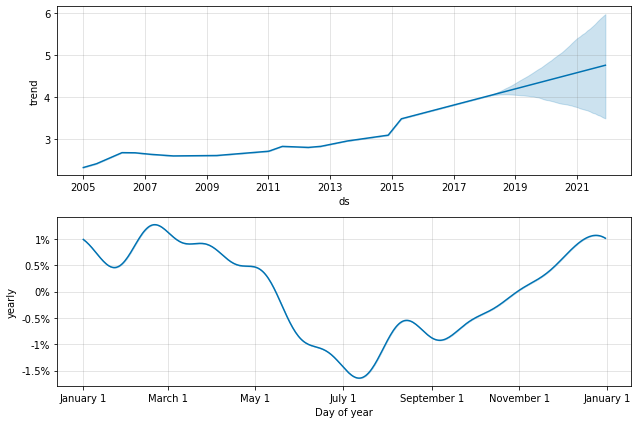

In [23]:
# Plota os componentes de tendência (trend) e da sazonalidade anual (yearly)
model_mul.plot_components(prediction_mul, );

In [24]:
# Cálculo dos resíduos da Gasolina

df_add = pd.merge(df_prophet_gasolina, prediction_add, on='ds')
df_mul = pd.merge(df_prophet_gasolina, prediction_mul, on='ds')
residuos_add = (df_add['y'] - df_add['yhat'])[12:144]
residuos_mul = (df_mul['y'] - df_mul['yhat'])[12:144]

# Residuals Standardized (Resíduos padronizados)
residuos_add_std = residuos_add/np.std(residuos_add)
residuos_mul_std = residuos_mul/np.std(residuos_mul)

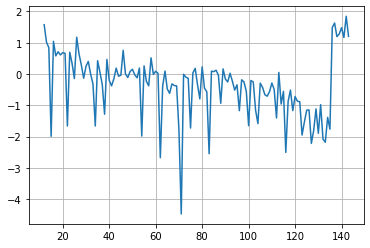

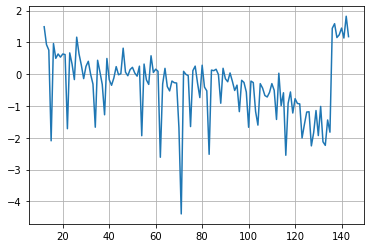

In [25]:
#Plotagem dos resíduos(diferença entre)
residuos_add_std.plot()
plt.grid(True, axis='both')
plt.show()

residuos_mul_std.plot()
plt.grid(True, axis='both')
plt.show()

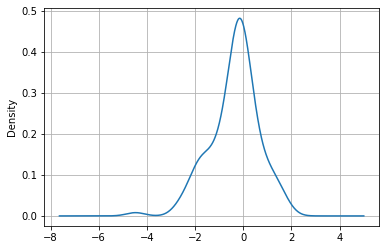

count    132.000000
mean      -0.354754
std        1.003810
min       -4.472075
25%       -0.874300
50%       -0.229841
75%        0.168205
max        1.847389
dtype: float64


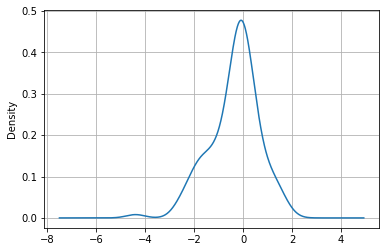

count    132.000000
mean      -0.349363
std        1.003810
min       -4.396725
25%       -0.918640
50%       -0.216820
75%        0.220598
max        1.822165
dtype: float64


In [26]:
#Plotagem da densidade dos resíduos(erros residuais)
residuos_add_std.plot(kind='kde')
plt.grid(True, axis='both')
plt.show()
print(residuos_add_std.describe())

residuos_mul_std.plot(kind='kde')
plt.grid(True, axis='both')
plt.show()
print(residuos_mul_std.describe())

In [27]:
# ETANOL

In [28]:
# Carrega o dataset referente ao Etanol e renomeia as colunas

df_prophet_etanol = df_combustiveis_dolar_ipca_nacional['ValorVendaEtanol'] 

df_prophet_etanol = df_prophet_etanol.reset_index(level=['Data'])

df_prophet_etanol = df_prophet_etanol.rename(columns={'Data':'ds','ValorVendaEtanol':'y'})

In [29]:
df_prophet_etanol

,ds,y
0,2005-01-03,1.750419
1,2005-01-04,1.719137
2,2005-01-05,1.740931
3,2005-01-06,1.704239
4,2005-01-10,1.744700
...,...,...
3506,2021-12-27,5.580209
3507,2021-12-28,5.629191
3508,2021-12-29,5.624709
3509,2021-12-30,5.453403


In [30]:
# Vamos realizar a previsão dos últimos 04 anos (2018 a 2021) comparando com o valor real

treino = df_prophet_etanol.loc[df_prophet_etanol['ds']<='2017-12-31']
teste  = df_prophet_etanol.loc[df_prophet_etanol['ds']>='2018-01-01']

In [31]:
# Instancia um objeto Prophet e cria o modelo

# modelo aditivo
forecaster_add = Prophet(seasonality_mode='additive', weekly_seasonality=False, daily_seasonality=False)
model_add = forecaster_add.fit(treino)

# modelo multiplicativo
forecaster_mul = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
model_mul = forecaster_mul.fit(treino)

In [32]:
print(model_add.seasonalities)
print(model_mul.seasonalities)

OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])
OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'multiplicative', 'condition_name': None})])


In [33]:
# Cria um dataframe com os períodos no futuro (48 meses)
future_ds = model_add.make_future_dataframe(periods=48, freq='MS', include_history=True)

In [34]:
# Realiza as predições
prediction_add = model_add.predict(future_ds)
prediction_mul = model_mul.predict(future_ds)

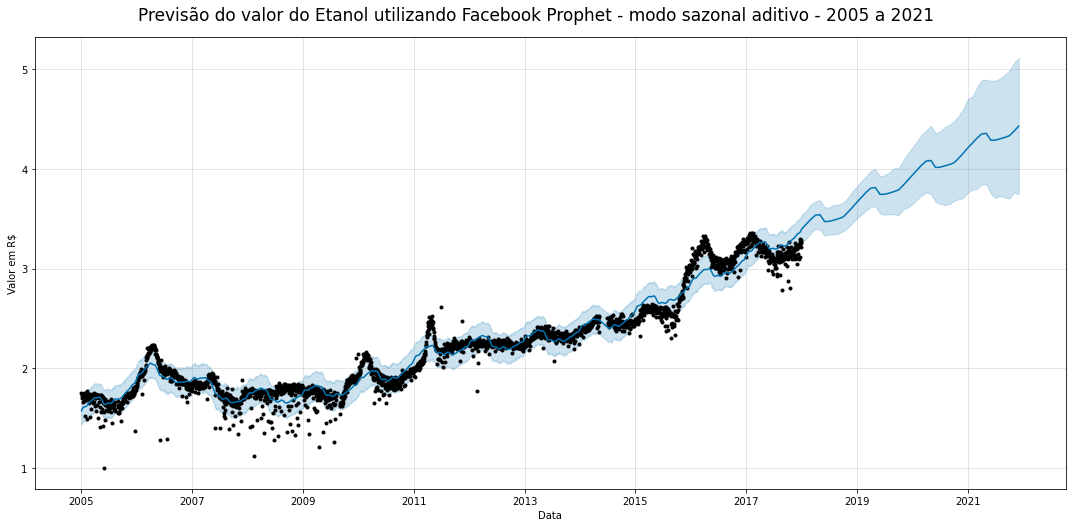

In [35]:
# Plota o valor efetivo "y" (pontos pretos), a previsão "yhat" é a linha azul escura
# A faixa azul clara representa o intervalo definido pelo limite inferior "yhat_lower" e limite superior "yhat_upper"

# modelo aditivo
fig = model_add.plot(prediction_add, figsize=(15,7), xlabel = 'Data', ylabel = 'Valor em R$', );
fig.suptitle('Previsão do valor do Etanol utilizando Facebook Prophet - modo sazonal aditivo - 2005 a 2021', 
             fontsize=17, y=1.04);

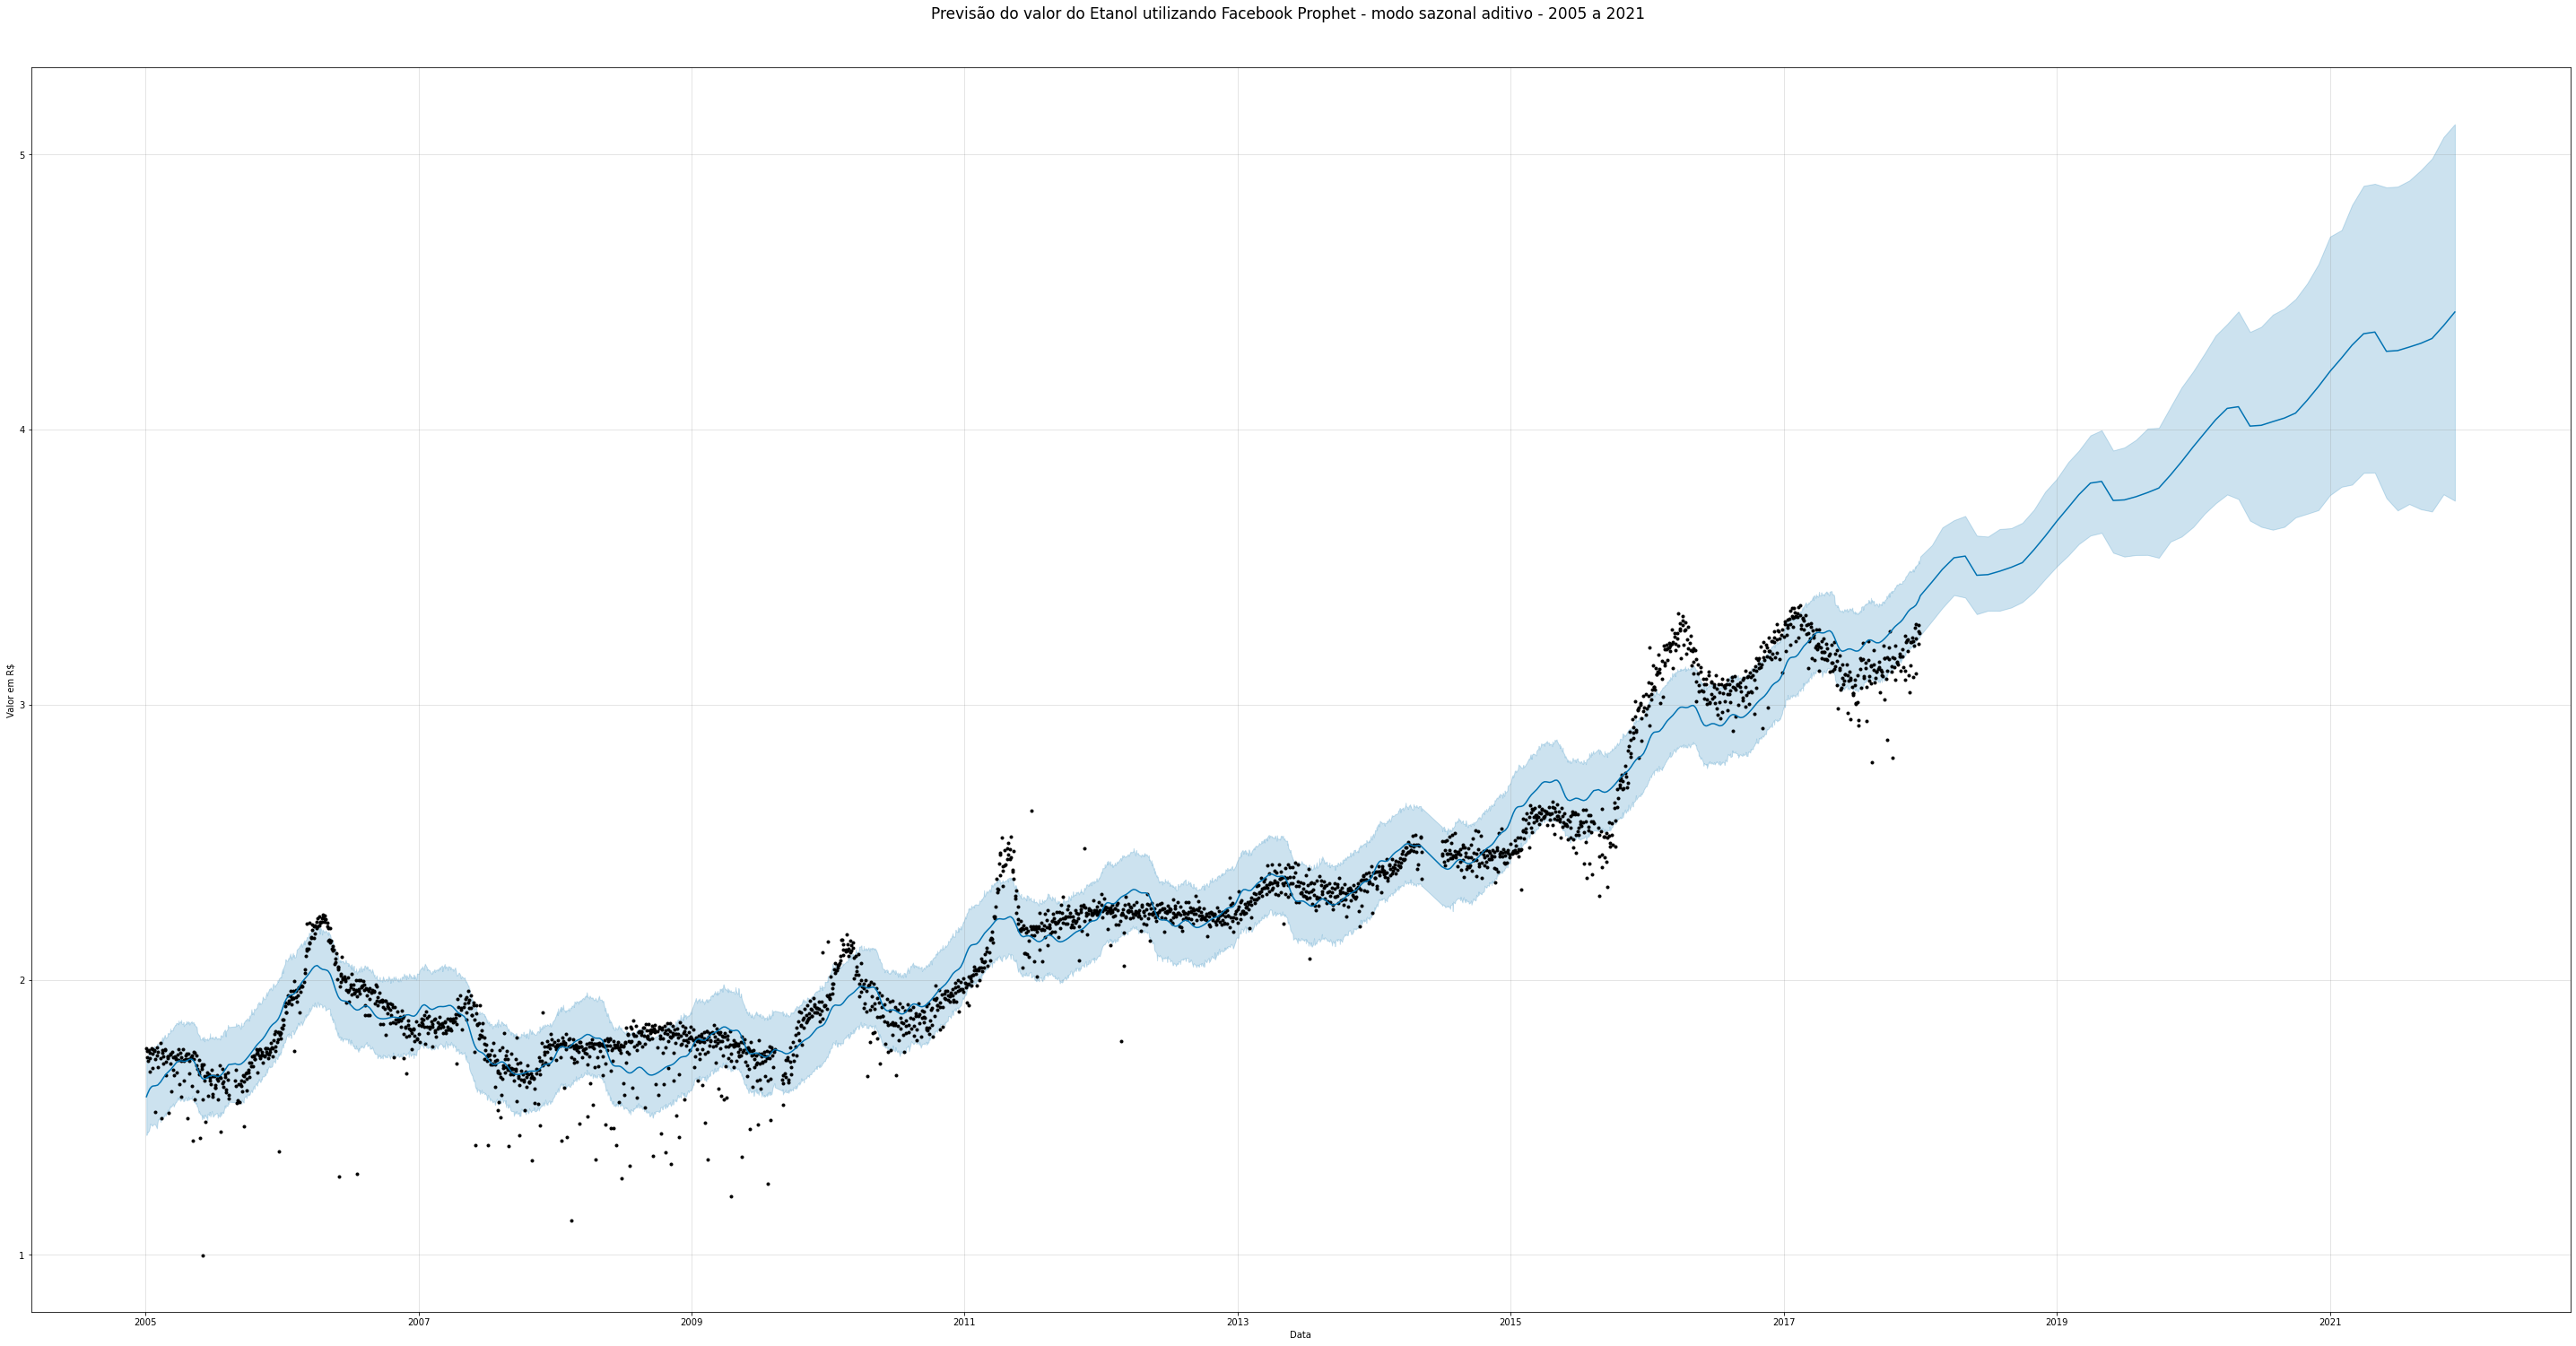

In [36]:
# TAMANHO MAIOR

# modelo aditivo
fig = model_add.plot(prediction_add, figsize=(40,20), xlabel = 'Data', ylabel = 'Valor em R$', );
fig.suptitle('Previsão do valor do Etanol utilizando Facebook Prophet - modo sazonal aditivo - 2005 a 2021', 
             fontsize=17, y=1.04);

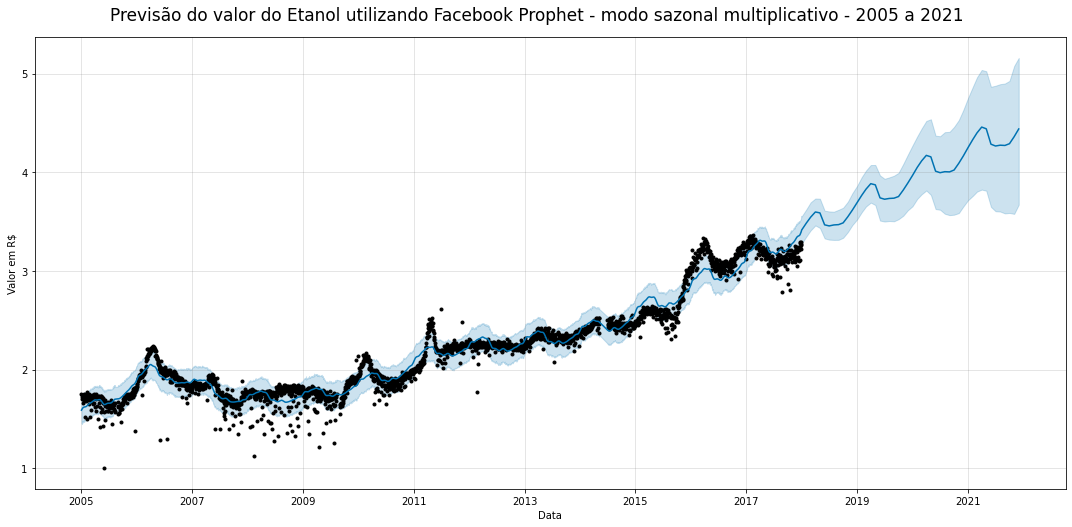

In [37]:
# Plota o valor efetivo  "y" (pontos pretos), a previsão "yhat" é a linha azul escura
# A faixa azul clara representa o intervalo definido pelo limite inferior "yhat_lower" e limite superior "yhat_upper"

# modelo multiplicativo
fig = model_mul.plot(prediction_mul, figsize=(15,7), xlabel = 'Data', ylabel = 'Valor em R$');
fig.suptitle('Previsão do valor do Etanol utilizando Facebook Prophet - modo sazonal multiplicativo - 2005 a 2021', 
             fontsize=17, y=1.04);

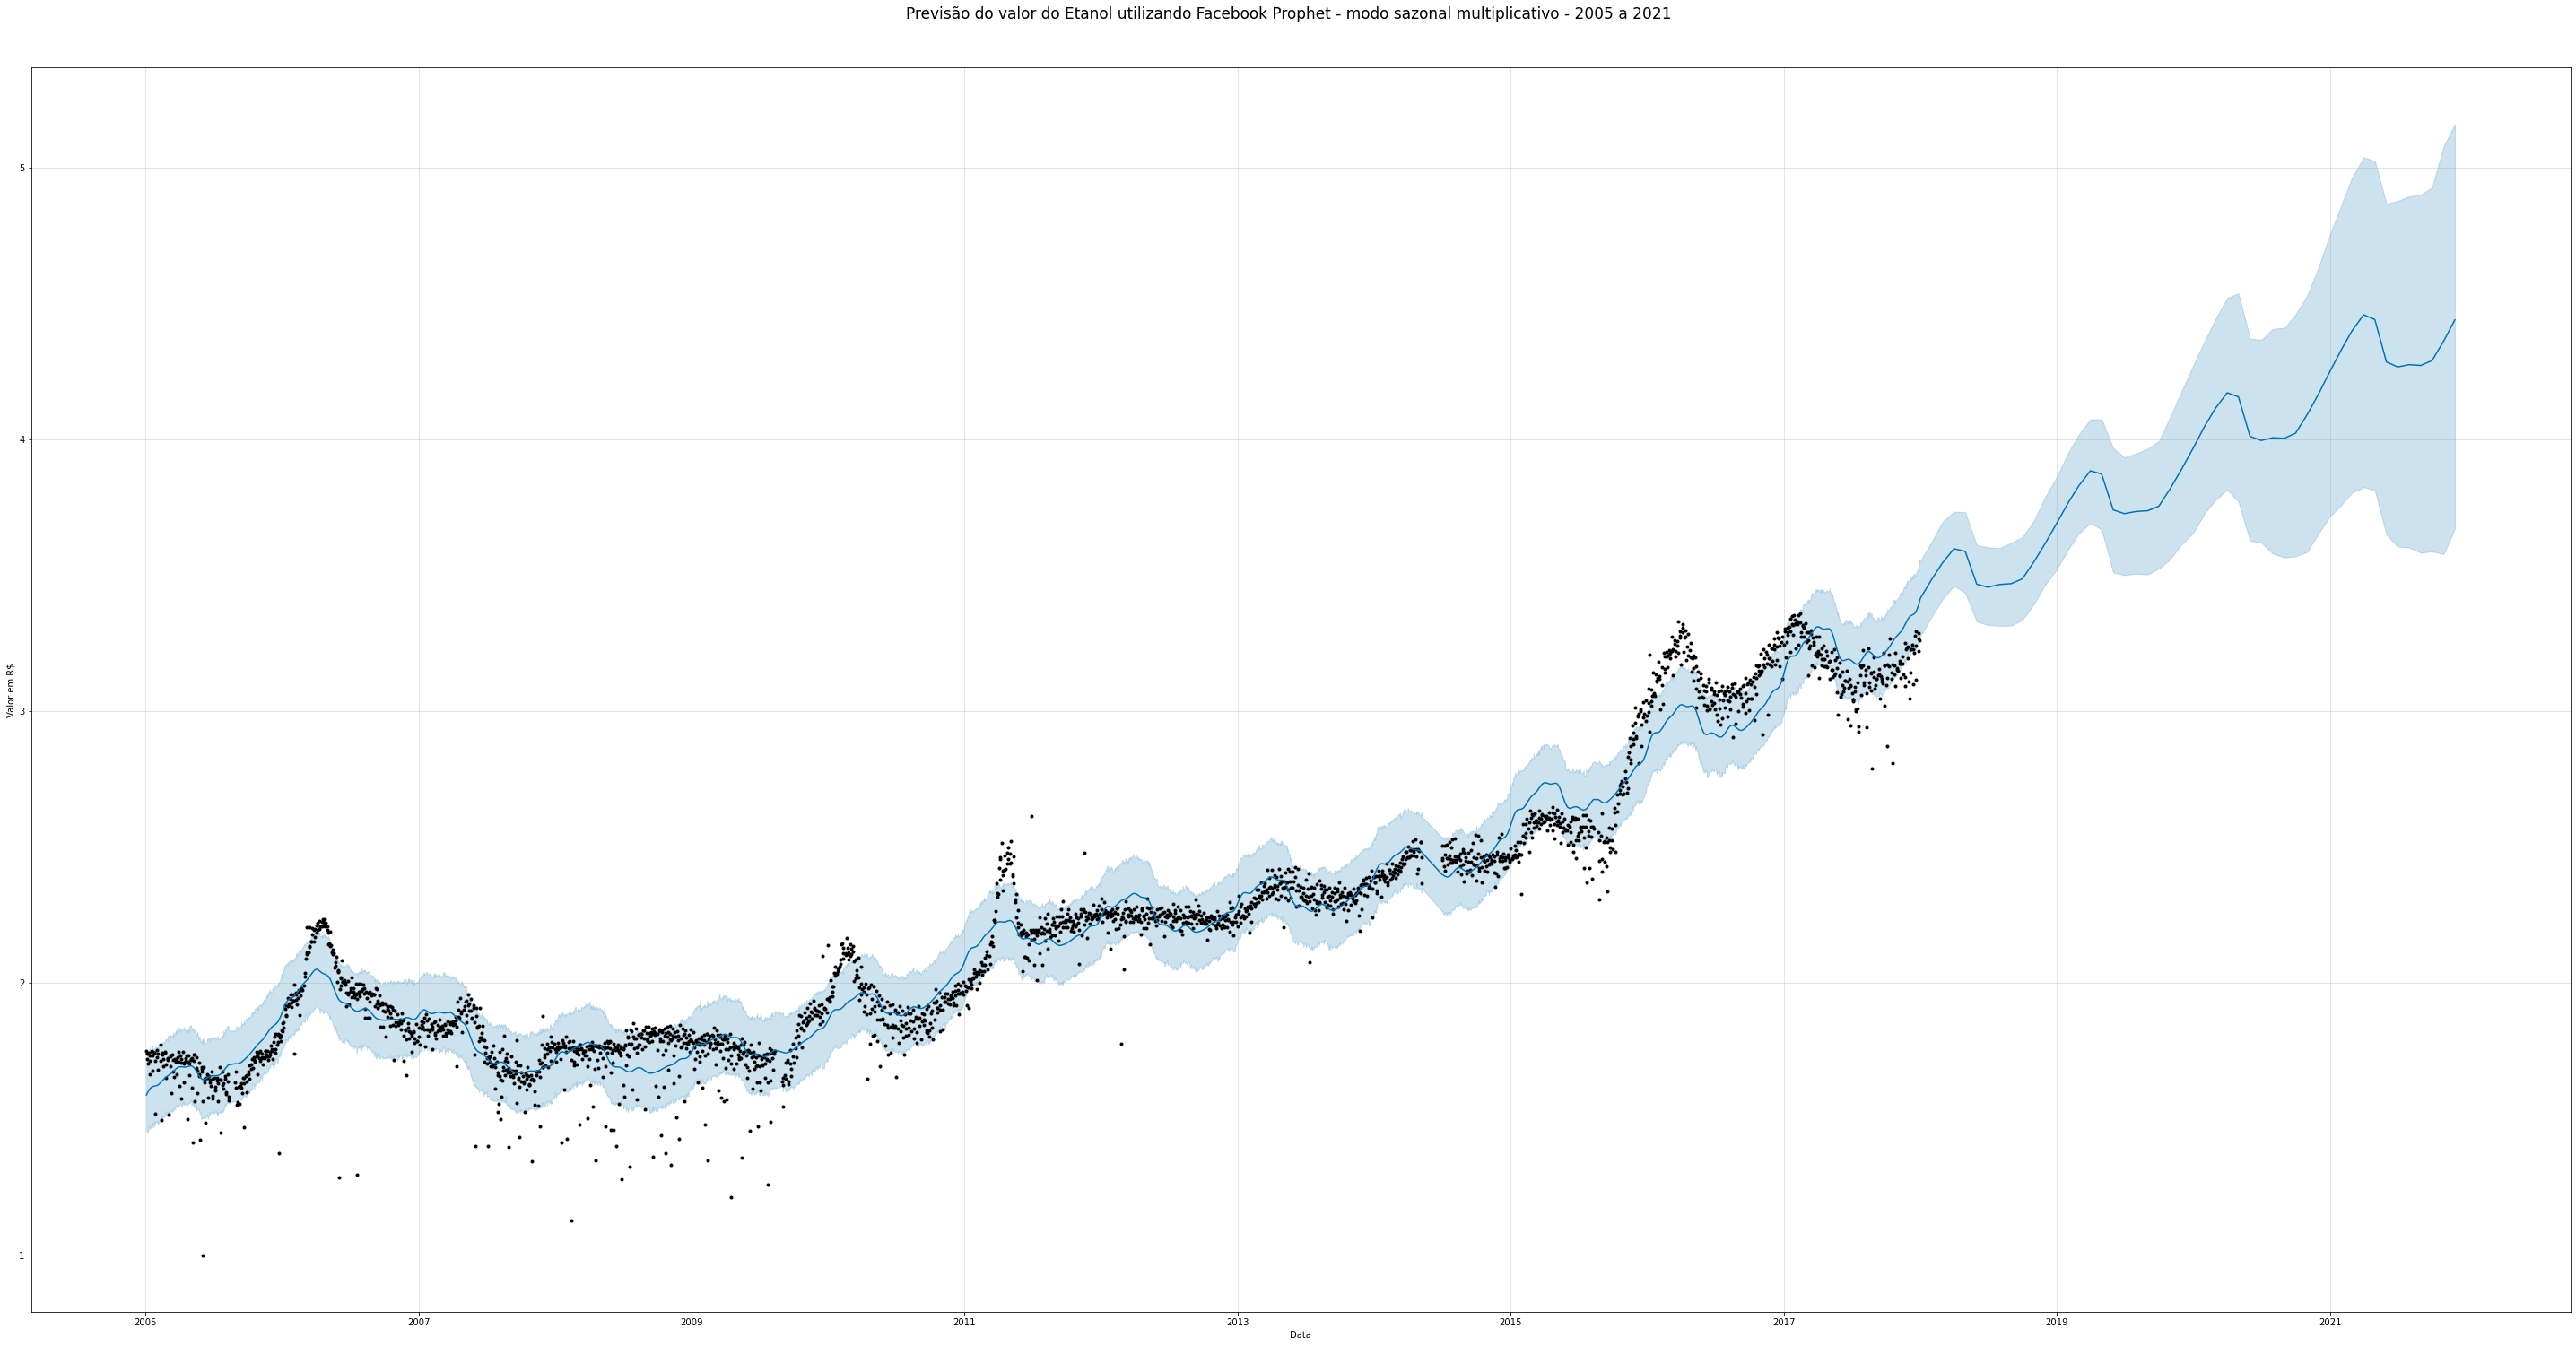

In [38]:
# TAMANHO MAIOR

# modelo multiplicativo
fig = model_mul.plot(prediction_mul, figsize=(40,20), xlabel = 'Data', ylabel = 'Valor em R$');
fig.suptitle('Previsão do valor do Etanol utilizando Facebook Prophet - modo sazonal multiplicativo - 2005 a 2021', 
             fontsize=17, y=1.04);

In [39]:
prediction_mul

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2005-01-03,1.570617,1.465266,1.726952,1.570617,1.570617,0.011417,0.011417,0.011417,0.011417,0.011417,0.011417,0.0,0.0,0.0,1.588549
1,2005-01-04,1.571233,1.454292,1.730886,1.571233,1.571233,0.012821,0.012821,0.012821,0.012821,0.012821,0.012821,0.0,0.0,0.0,1.591378
2,2005-01-05,1.571850,1.457114,1.728793,1.571850,1.571850,0.014194,0.014194,0.014194,0.014194,0.014194,0.014194,0.0,0.0,0.0,1.594161
3,2005-01-06,1.572467,1.447218,1.733112,1.572467,1.572467,0.015521,0.015521,0.015521,0.015521,0.015521,0.015521,0.0,0.0,0.0,1.596872
4,2005-01-10,1.574933,1.477865,1.743013,1.574933,1.574933,0.020102,0.020102,0.020102,0.020102,0.020102,0.020102,0.0,0.0,0.0,1.606591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,2021-08-01,4.374291,3.602022,4.893696,3.688190,4.993678,-0.022735,-0.022735,-0.022735,-0.022735,-0.022735,-0.022735,0.0,0.0,0.0,4.274843
2726,2021-09-01,4.397678,3.583093,4.900365,3.684707,5.031598,-0.028525,-0.028525,-0.028525,-0.028525,-0.028525,-0.028525,0.0,0.0,0.0,4.272233
2727,2021-10-01,4.420311,3.587925,4.926907,3.682212,5.076827,-0.029476,-0.029476,-0.029476,-0.029476,-0.029476,-0.029476,0.0,0.0,0.0,4.290018
2728,2021-11-01,4.443698,3.578288,5.078588,3.681356,5.128159,-0.018499,-0.018499,-0.018499,-0.018499,-0.018499,-0.018499,0.0,0.0,0.0,4.361494


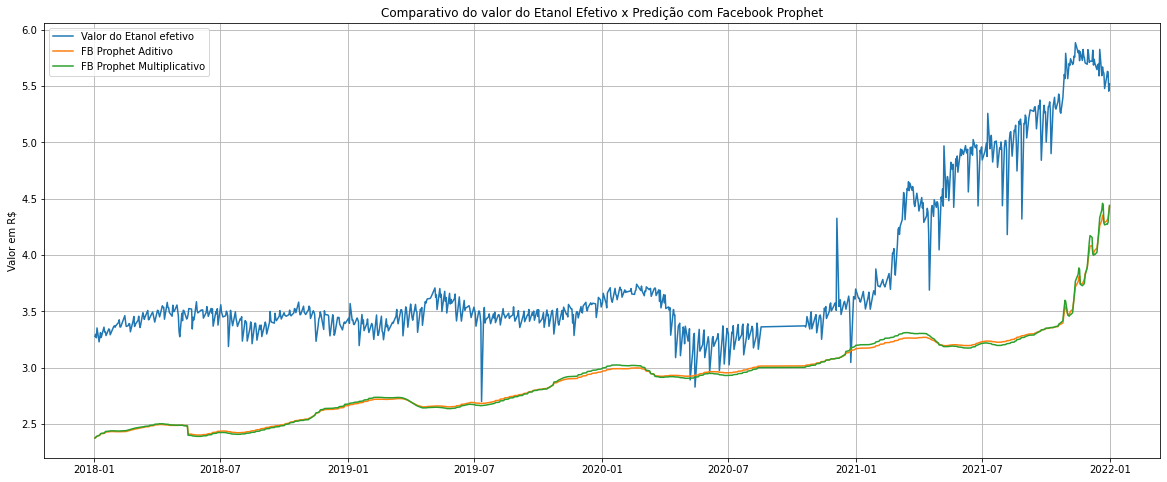

In [40]:
# Comparativo valores das predições e efetivos
plt.figure(figsize = (20,8))
plt.plot(teste['ds'], teste['y'], label = "Valor do Etanol efetivo")
plt.plot(teste['ds'], prediction_add['yhat'][-829:], label = "FB Prophet Aditivo")
plt.plot(teste['ds'], prediction_mul['yhat'][-829:], label = "FB Prophet Multiplicativo")
plt.title('Comparativo do valor do Etanol Efetivo x Predição com Facebook Prophet')
plt.ylabel('Valor em R$')
plt.legend(loc = 'upper left')
plt.grid(True, axis='both')
plt.show()

In [41]:
#yhat é o valor predito, yhat_lower e upper são os valores para intervalo de
#confiança
prediction_mul[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2725,2021-08-01,4.274843,3.602022,4.893696
2726,2021-09-01,4.272233,3.583093,4.900365
2727,2021-10-01,4.290018,3.587925,4.926907
2728,2021-11-01,4.361494,3.578288,5.078588
2729,2021-12-01,4.439455,3.671376,5.159750


In [42]:
# Testes de performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

efetivo = teste['y']
predicao_add = prediction_add['yhat'][-829:]
predicao_mul = prediction_mul['yhat'][-829:]

# Calcula o erro RMSE
rmse_add = np.sqrt(mean_squared_error(efetivo, predicao_add))
rmse_mul = np.sqrt(mean_squared_error(efetivo, predicao_mul))

# Cálculo do coeficiente de determinação, também chamado de R²
r2_add = r2_score(efetivo, predicao_add)
r2_mul = r2_score(efetivo, predicao_mul)

# Mean absolute percentage error (MAPE) - a measure of prediction accuracy of a forecasting method in statistics
mape_add = mean_absolute_percentage_error(efetivo, predicao_add) * 100
mape_mul = mean_absolute_percentage_error(efetivo, predicao_mul) * 100

In [43]:
print(f'RMSE aditivo: {rmse_add:.2f}')
print(f'RMSE multiplicativo: {rmse_mul:.2f}\n')

print(f'R2 aditivo: {r2_add:.2f}')
print(f'R2 multiplicativo: {r2_mul:.2f}\n')

print(f'MAPE aditivo: {mape_add:.2f}%')
print(f'MAPE multiplicativo: {mape_mul:.2f}%')

RMSE aditivo: 1.06
RMSE multiplicativo: 1.06

R2 aditivo: -1.09
R2 multiplicativo: -1.09

MAPE aditivo: 23.42%
MAPE multiplicativo: 23.39%


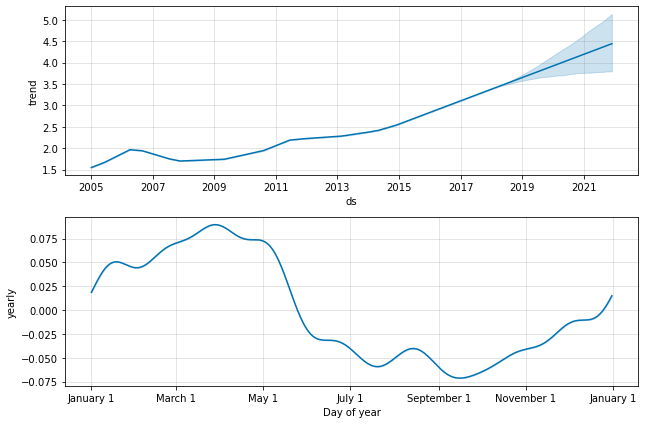

In [44]:
# Plota os componentes de tendência (trend) e da sazonalidade anual (yearly)
model_add.plot_components(prediction_add, );

C:\Users\vinic\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


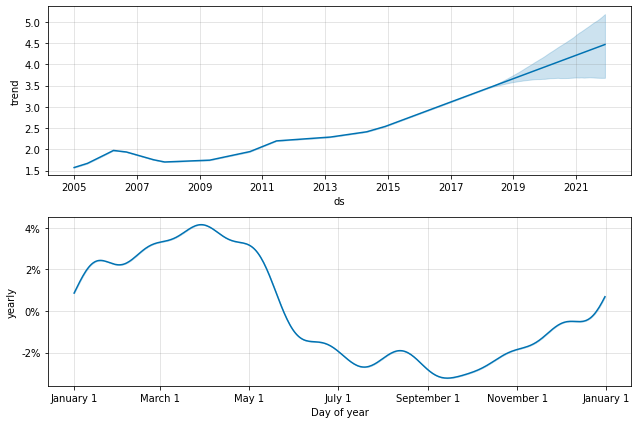

In [45]:
# Plota os componentes de tendência (trend) e da sazonalidade anual (yearly)
model_mul.plot_components(prediction_mul, );

In [46]:
# Cálculo dos resíduos do Etanol

df_add = pd.merge(df_prophet_etanol, prediction_add, on='ds')
df_mul = pd.merge(df_prophet_etanol, prediction_mul, on='ds')
residuos_add = (df_add['y'] - df_add['yhat'])[12:144]
residuos_mul = (df_mul['y'] - df_mul['yhat'])[12:144]

# Residuals Standardized (Resíduos padronizados)
residuos_add_std = residuos_add/np.std(residuos_add)
residuos_mul_std = residuos_mul/np.std(residuos_mul)

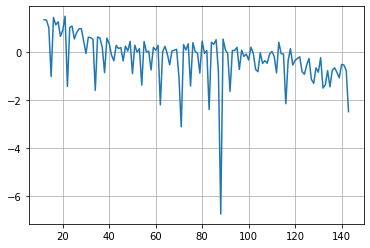

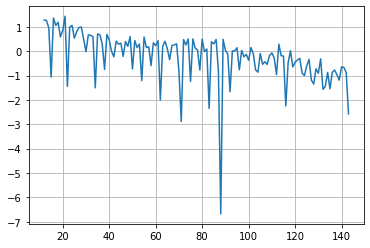

In [47]:
#Plotagem dos resíduos(diferença entre)
residuos_add_std.plot()
plt.grid(True, axis='both')
plt.show()

residuos_mul_std.plot()
plt.grid(True, axis='both')
plt.show()

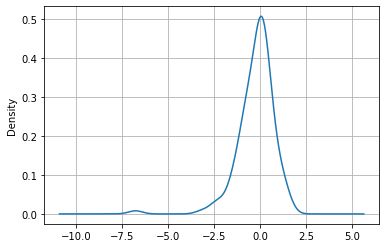

count    132.000000
mean      -0.216737
std        1.003810
min       -6.756479
25%       -0.721104
50%       -0.036911
75%        0.327655
max        1.509237
dtype: float64


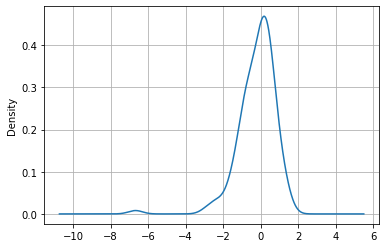

count    132.000000
mean      -0.214515
std        1.003810
min       -6.676735
25%       -0.752858
50%       -0.013797
75%        0.415535
max        1.430879
dtype: float64


In [48]:
#Plotagem da densidade dos resíduos(erros residuais)
residuos_add_std.plot(kind='kde')
plt.grid(True, axis='both')
plt.show()
print(residuos_add_std.describe())

residuos_mul_std.plot(kind='kde')
plt.grid(True, axis='both')
plt.show()
print(residuos_mul_std.describe())